In [337]:
#Load the required libraries
import pandas as pd
import numpy as np
import seaborn as sns
from prophet import Prophet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [338]:
#Load the data
df = pd.read_csv('sorted_data.csv')
df.head()

,FIPS,Province_State,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incident_Rate,Case_Fatality_Ratio,Year
0,12-31-2020,Tamil Nadu,01-01-2021 05:23,11.006091,78.400624,817077,12109,796353,8615.0,"Tamil Nadu, India",1049.670736,1.481990,2020
1,12-30-2020,Tamil Nadu,31-12-2020 05:22,11.006091,78.400624,817077,12109,796353,8615.0,"Tamil Nadu, India",1049.670736,1.481990,2020
2,12-29-2020,Tamil Nadu,30-12-2020 05:22,11.006091,78.400624,816132,12092,795293,8747.0,"Tamil Nadu, India",1048.456727,1.481623,2020
3,12-28-2020,Tamil Nadu,29-12-2020 05:22,11.006091,78.400624,815175,12080,794228,8867.0,"Tamil Nadu, India",1047.227302,1.481890,2020
4,12-27-2020,Tamil Nadu,28-12-2020 05:22,11.006091,78.400624,814170,12069,793154,8947.0,"Tamil Nadu, India",1045.936213,1.482369,2020


In [339]:
df = df.drop(['Deaths','Confirmed','Recovered','Province_State','Last_Update','Lat','Long_','Combined_Key','Incident_Rate','Case_Fatality_Ratio','Year'],axis=1)
#View the data ['Deaths','Confirmed']
df.head()

,FIPS,Active
0,12-31-2020,8615.0
1,12-30-2020,8615.0
2,12-29-2020,8747.0
3,12-28-2020,8867.0
4,12-27-2020,8947.0


In [340]:
#df['abs_diff'] = df['Active'].diff().abs()

In [341]:
df.head()

,FIPS,Active
0,12-31-2020,8615.0
1,12-30-2020,8615.0
2,12-29-2020,8747.0
3,12-28-2020,8867.0
4,12-27-2020,8947.0


In [342]:
df = df.dropna().reset_index(drop=True)


In [343]:
df['FIPS'] = pd.to_datetime(df['FIPS'])
df.sort_values(by='FIPS')
# df.drop(pd.date_range('2020-06-10', '2020-12-31'),axis=1)

# date_filter = (df['FIPS'] < '2020-06-10') | (df['FIPS'] > '2020-12-31')
# filtered_df = df[date_filter]
# df =filtered_df
df

,FIPS,Active
0,2020-12-31,8615.000000
1,2020-12-30,8615.000000
2,2020-12-29,8747.000000
3,2020-12-28,8867.000000
4,2020-12-27,8947.000000
...,...,...
998,2023-01-05,4617.713892
999,2023-01-04,4617.702330
1000,2023-01-03,4617.686914
1001,2023-01-02,4617.674067


In [344]:
df.rename(columns = {'FIPS':'ds','Active':'y'}, inplace = True)

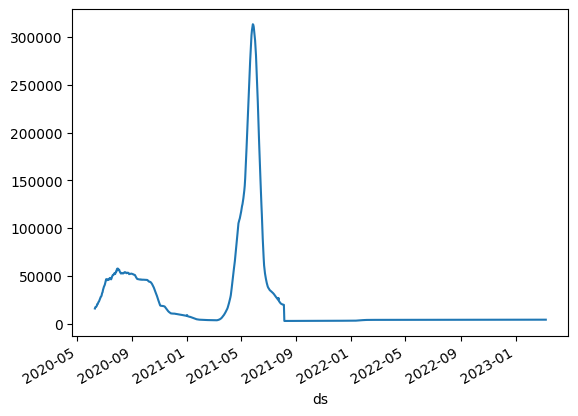

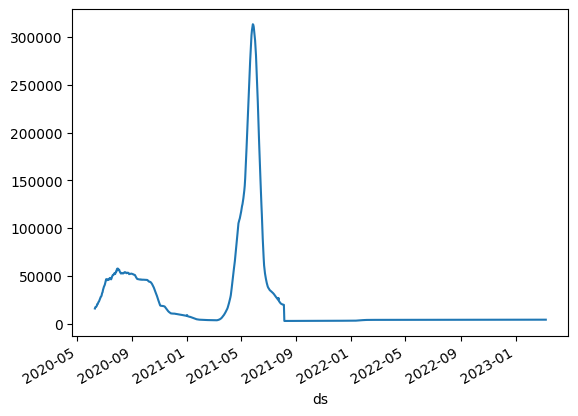

In [345]:
df.set_index('ds').y.plot().get_figure()

In [419]:
#m = Prophet()
m = Prophet(changepoint_prior_scale=0.7, seasonality_prior_scale=30, holidays_prior_scale=20, n_changepoints=50, seasonality_mode='multiplicative')
#m= Prophet(changepoint_prior_scale=0.5, seasonality_prior_scale=50, holidays_prior_scale=50, n_changepoints=50, seasonality_mode='multiplicative')
m = m.fit(df)
future = m.make_future_dataframe(periods=100)
forecast = m.predict(future)

16:01:02 - cmdstanpy - INFO - Chain [1] start processing
16:01:05 - cmdstanpy - INFO - Chain [1] done processing


Text(0.5, 1.0, 'Active Case Forecast')

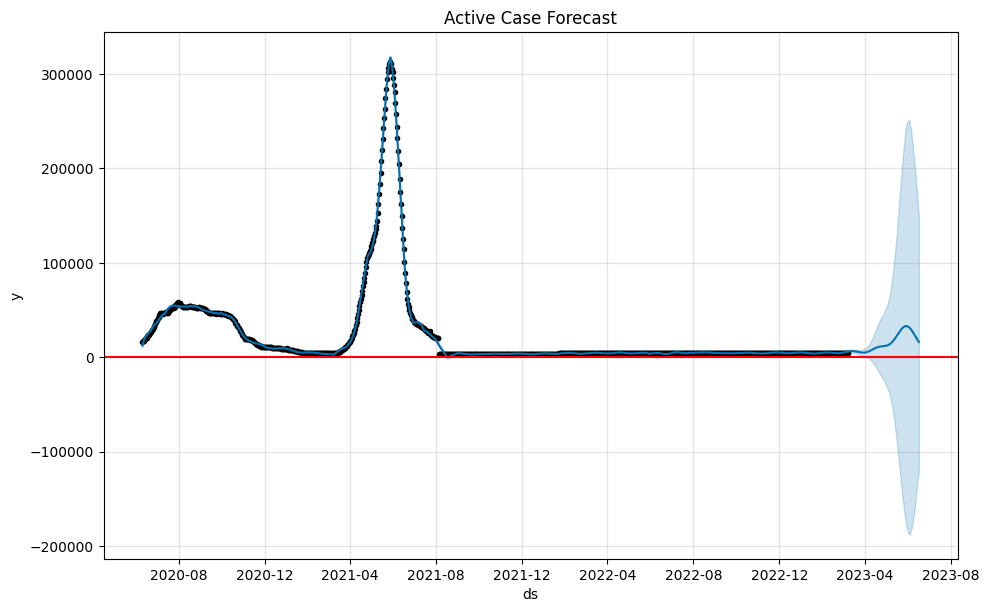

In [384]:
m.plot(forecast)
plt.axhline(y=0, color='red')
plt.title('Active Case Forecast')

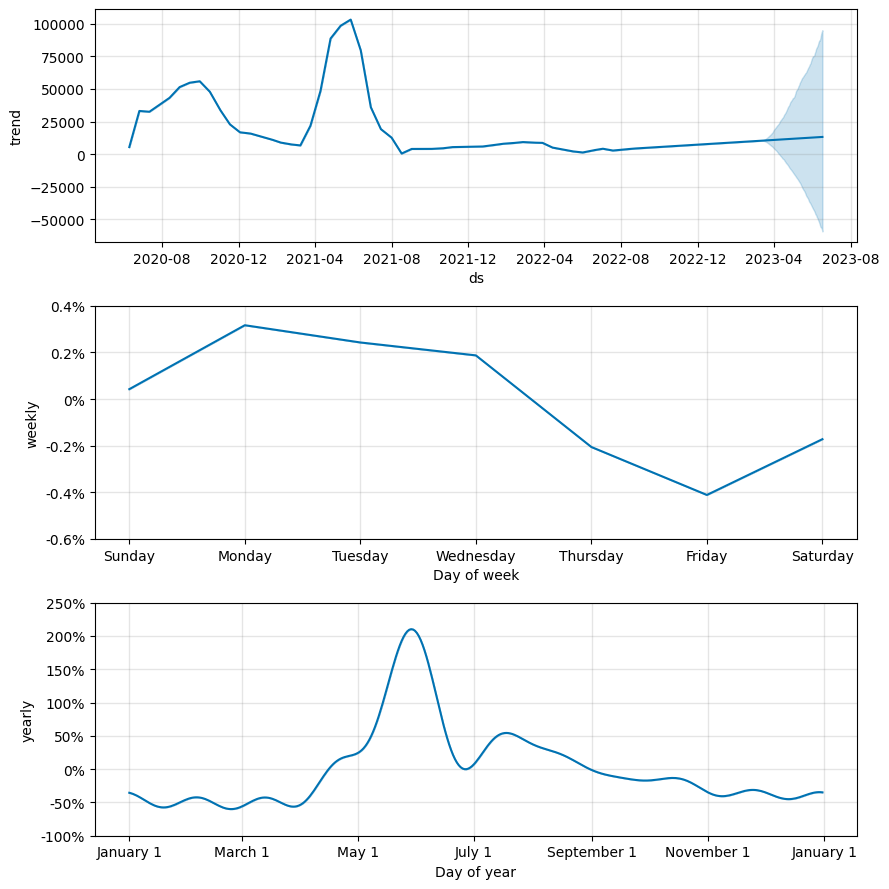

In [382]:
m.plot_components(forecast);

In [420]:
from prophet.diagnostics import cross_validation

df_cv = cross_validation(m, initial='600 days', period='380 days', horizon = '100 days')

  0%|          | 0/1 [00:00<?, ?it/s]

16:01:20 - cmdstanpy - INFO - Chain [1] start processing
16:01:22 - cmdstanpy - INFO - Chain [1] done processing


In [310]:
df_cv.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
195,2023-03-05,104653.362879,66907.011823,141199.765105,4618.375495,2022-11-29
196,2023-03-06,105271.188339,64821.548966,142168.546103,4618.410181,2022-11-29
197,2023-03-07,105854.416622,67194.099963,143924.632156,4618.446151,2022-11-29
198,2023-03-08,106713.285398,68708.230335,145896.438583,4618.487261,2022-11-29
199,2023-03-09,107038.240165,66961.175676,146627.419661,4618.530939,2022-11-29


In [311]:
# cutoffs = pd.to_datetime(['2013-02-15', '2013-08-15', '2014-02-15'])
# df_cv2 = cross_validation(m, cutoffs=cutoffs, horizon='365 days')

In [421]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,10 days,14275.606650,119.480570,105.158462,0.022775,0.020821,0.023114,1.0
1,11 days,14242.530208,119.342072,104.976407,0.022735,0.020654,0.023036,1.0
2,12 days,19044.610523,138.002212,116.990847,0.025337,0.020654,0.025437,1.0
3,13 days,34934.194965,186.906915,143.139334,0.031000,0.020654,0.030605,1.0
4,14 days,64493.243274,253.955199,181.047303,0.039210,0.020654,0.037978,1.0


In [415]:
df_p.tail()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
86,96 days,1.310248e+06,1144.660769,841.422946,0.182198,0.139909,0.156496,1.0
87,97 days,7.632229e+05,873.626319,614.617038,0.133086,0.083735,0.117614,1.0
88,98 days,4.332668e+05,658.230081,442.896660,0.095902,0.039360,0.086889,1.0
89,99 days,2.252122e+05,474.565324,315.256946,0.068263,0.030199,0.063456,1.0
90,100 days,1.048780e+05,323.848783,226.365232,0.049015,0.030199,0.046713,1.0


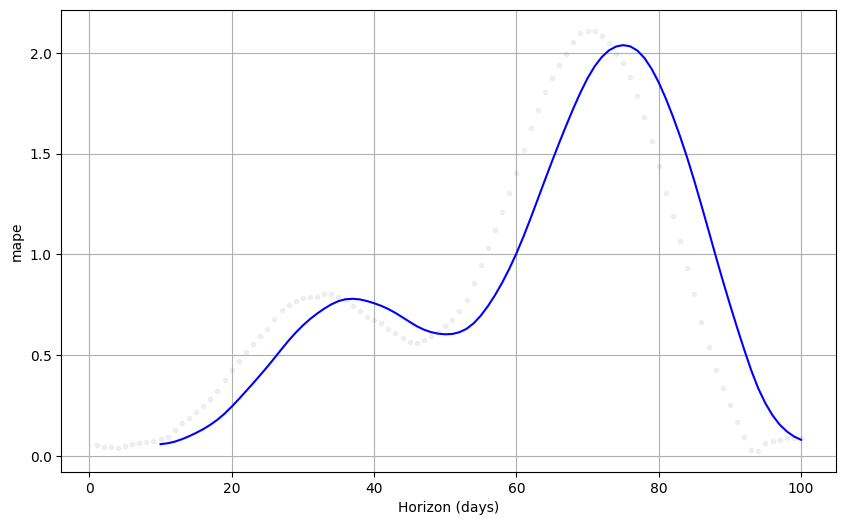

In [372]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')